<a href="https://colab.research.google.com/github/Casardo-Chen/wikiart-neural-trasnfer/blob/main/VAE_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Data from Google Drive


In [210]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Libraries and utilities

In [211]:
############################
######## libraries #########
############################
# system
import os
# data science
import numpy as np
import pandas as pd
# visualization
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
# pytorch(neural networks)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
# vision
import torchvision.utils as vutils
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import cv2

!pip install jovian --upgrade --quiet
import jovian

In [212]:
PROJECT = 'Abstract Art VAE'

In [213]:
# explore some art pictures
mode = 'google drive'
if mode == 'google drive':
  DATA_DIR = './drive/MyDrive/NN/wikiart-neural-transfer-GAN/Abstract_gallery/'
elif mode == 'local':
  DATA_DIR = './Data/Abstract_gallery/'
print(os.listdir(DATA_DIR))
print(os.listdir(DATA_DIR+'/Abstract_gallery')[:10])

['Abstract_gallery']
['Abstract_image_2587.jpg', 'Abstract_image_2529.jpg', 'Abstract_image_2556.jpg', 'Abstract_image_2604.jpg', 'Abstract_image_2483.jpg', 'Abstract_image_2507.jpg', 'Abstract_image_2581.jpg', 'Abstract_image_2554.jpg', 'Abstract_image_2520.jpg', 'Abstract_image_2591.jpg']


In [214]:
###########################
##### set parameters ######
###########################
image_size = (64,64)      # size of each image
batch_size = 100           # how many images are processing at once
latent_size = 100         # the dimensionality of the random noise vector that is used as input to the generator network
epoch_restore = 150       # epoch times

checkpoint_path = "../input/abstract-art-generation-dcgan-checkpoints/{}epochs.chkpt".format(epoch_restore)

learning_rate = 0.0002
beta1 = 0.5               # the exponential decay rate for the first moment estimate in the Adam optimizer
epochs = 100

# model hyperparameters:
latent_dim = 200
h_dims = [32, 64, 128, 256, 512]
x_dim  = 12288

# load data
dataset = ImageFolder(root=DATA_DIR,
                      transform= T.Compose([T.Resize(image_size),
                                            T.ToTensor(),
                                            T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])           
                      )
dataloader = DataLoader(dataset=dataset, batch_size=batch_size,shuffle=True,num_workers=2)

# prep device
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")

# split into training set and test set
n = len(dataset)  # total number of examples
n_test = int(0.1 * n)  # take ~10% for test
testset = torch.utils.data.Subset(dataset, range(n_test))  # take first 10%
trainset = torch.utils.data.Subset(dataset, range(n_test, n))  # take the rest   
trainloader = DataLoader(dataset=trainset, batch_size=batch_size,shuffle=True,num_workers=2)
testloader = DataLoader(dataset=testset, batch_size=batch_size,shuffle=True,num_workers=2)


In [215]:
# getting a batch from the dataloader 
batch = next(iter(trainloader))

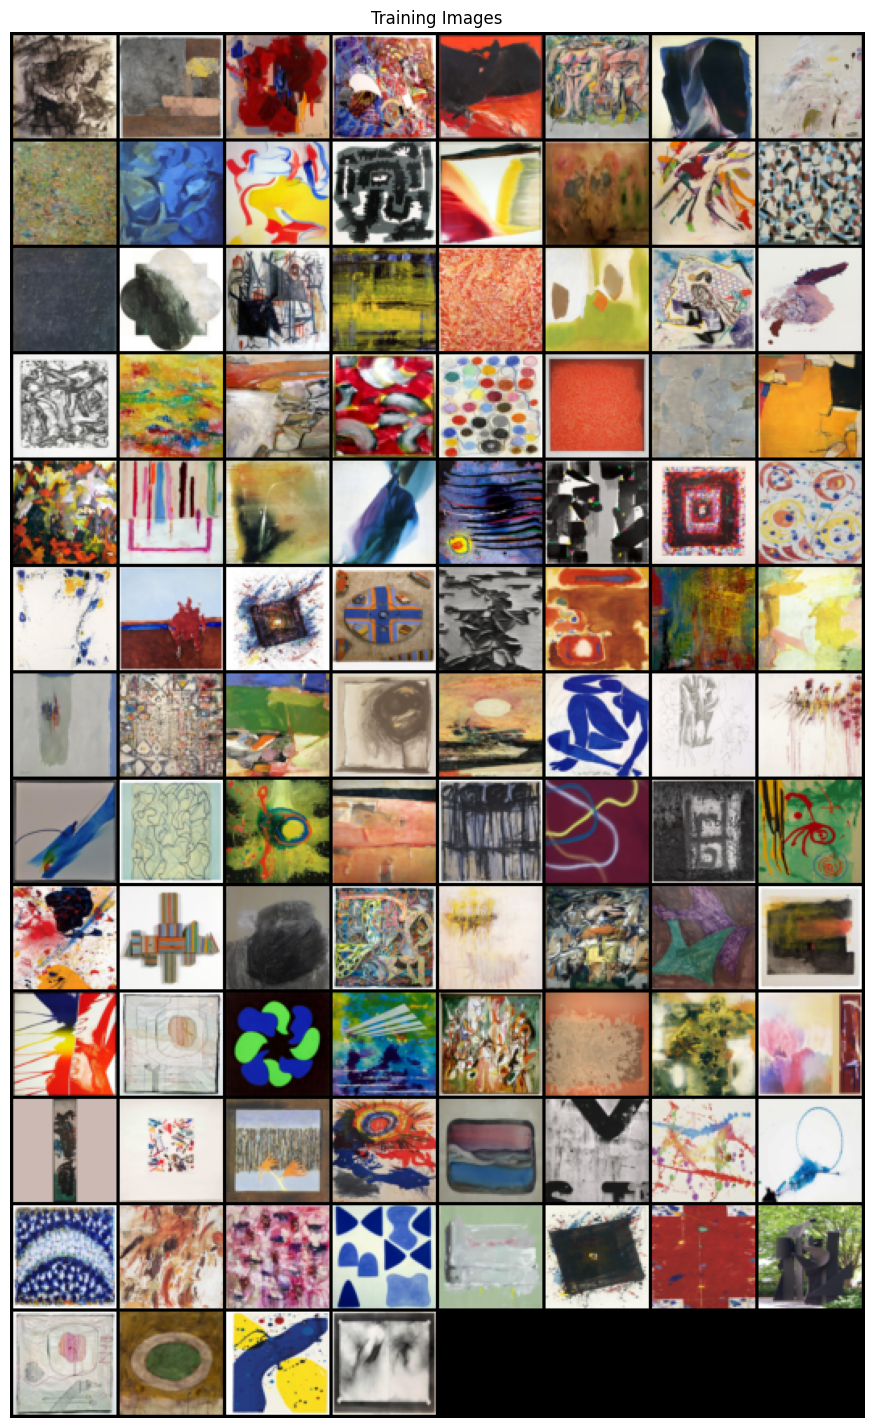

In [216]:
plt.figure(figsize=(18,18))
plt.axis("off")
plt.title("Training Images")
# viewing the training data 
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:batch_size], padding=2, normalize=True).cpu(),(1,2,0)))

## VAE Model

In [217]:
############################
######### Encoder ##########
############################
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dims, latent_dim):
        super(Encoder, self).__init__()
        if hidden_dims is None:
            hidden_dims = [32,64, 128, 256, 512]
        modules = []
        in_chan = 3

        # Build Encoder
        '''
        conv1: input 3*64*64; output: 32*32*32 [32=(64-4+2)/2+1]
        conv2: input 32*32*32; output: 64*16*16 [16=(32-4+2)/2+1]
        conv3: input 64*16*16; output: 128*8*8 [8=(16-4+2)/2+1]
        conv4: input 128*8*8; output: 256*4*4 [4=(16-4+2)/2+1]
        conv5: input 256*4*4; output: 512*2*2 [2=(16-4+2)/2+1]
        '''

        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels = in_chan, out_channels=h_dim,
                              kernel_size = 4, 
                              stride = 2, 
                              padding = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_chan = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*4, latent_dim)

        
    def forward(self, x):
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        param input: (Tensor) Input tensor to encoder [N x Channel x Height x Width]
        return: (Tensor) List of latent codes
        """
        result = self.encoder(x)
        # print(result.size())
        result = torch.flatten(result, start_dim=1)
        # print(f'flatten:{result.size()}')
        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)
        return mu, log_var

In [228]:
############################
######### Decoder ##########
############################
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dims, output_dim):
        super(Decoder, self).__init__()
        if hidden_dims is None:
            hidden_dims = [512, 256, 128, 64, 32]
        modules = []
        self.decoder_input = nn.Linear(latent_dim, hidden_dims[0] * 4)

        # Build Decoder
        '''
        H_out = (H_in−1)×stride−2×padding+(kernel−1)+output_padding+1
        conv1: input 512*2*2; output: 256*7*7 [2*2-2*1+(4-1)+1=7]
        conv2: input 256*7*7; output: 128*16*16 [7*2-2*1+(4-1)+1=16]
        conv3: input 128*16*16; output: 64*34*34 [16*2-2*1+(4-1)+1=34]
        conv4: input 128*8*8; output: 256*4*4 [4=(16-4+2)/2+1]
        conv5: input 256*4*4; output: 512*2*2 [2=(16-4+2)/2+1]
        '''
        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding = 1,
                                      output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )

        self.decoder = nn.Sequential(*modules)
        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels = 3,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())

        
    def forward(self, z):
        """
        Maps the given latent codes
        onto the image space.
        param z: (Tensor) [B x D]
        return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, 512, 2, 2)
        result = self.decoder(result)
        print(f'decoder:{result.size()}')
        result = self.final_layer(result)
        print(f'final:{result.size()}')
        return result

In [229]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)      # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z     
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat = self.Decoder(z)
        return x_hat, mean, log_var

In [230]:
encoder = Encoder(input_dim=x_dim, hidden_dims=h_dims, latent_dim=latent_dim)
new_h_dims = h_dims.copy()
new_h_dims.reverse()
decoder = Decoder(latent_dim=latent_dim, hidden_dims = new_h_dims, output_dim = x_dim)
model = Model(Encoder=encoder, Decoder=decoder).to(device)

## Loss Function and Optimization

In [231]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD

optimizer = Adam(model.parameters(), lr=learning_rate, betas=(beta1, 0.999))

## Training

In [232]:
################################
######## Training Loop #########
################################
img_list = []
iters = 0
G_losses = []
D_losses = []
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for i, (x,_) in enumerate(trainloader,0):
      x = x.to(device)
      optimizer.zero_grad()

      x_hat, mean, log_var = model(x)
      loss = loss_function(x, x_hat, mean, log_var)
        
      overall_loss += loss.item()
        
      loss.backward()
      optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (i*batch_size))
    
print("Finish training VAE")

Start training VAE...
decoder:torch.Size([100, 32, 32, 32])
final:torch.Size([100, 3, 64, 64])


RuntimeError: ignored